# First- and second-level modeling
Natalia Vélez, February 2019

This script does first- and second-level modeling, using outputs from fmriprep. Our workflow is based on [this script](https://github.com/poldrack/fmri-analysis-vm/blob/master/analysis/postFMRIPREPmodelling) from the Poldrack Lab repository.

Load libraries:

In [1]:
from IPython.display import Image # Debug

import os  # system functions
import pandas as pd
import glob
import numpy as np
import json
from os.path import join as opj
import nipype.interfaces.io as nio  # Data i/o
import nipype.interfaces.fsl as fsl  # fsl
from nipype.interfaces import utility as niu  # Utilities
import nipype.pipeline.engine as pe  # pypeline engine
import nipype.algorithms.modelgen as modelgen  # model generation
import nipype.algorithms.rapidart as ra  # artifact detection

from nipype.workflows.fmri.fsl import (create_featreg_preproc,
                                       create_modelfit_workflow,
                                       create_fixed_effects_flow)

from nipype import config
config.enable_debug_mode()

Project directory and function inputs:

In [2]:
# For testing (COMMENT)
project = 'SwiSt'
subject = 'sub-04'
task = 'tomloc'
model = 'localizer'
n_runs = 2
runs = list(range(1, n_runs+1))

# Location of project
scratch_dir = os.environ['PI_SCRATCH']
project_dir = opj(scratch_dir, project, 'BIDS_data')
derivatives_dir = opj(project_dir, 'derivatives')
work_dir = opj(scratch_dir, 'swist_cache', 'l1_model', 'task-%s_model-%s_%s' %(task, model, subject))

# DEBUG
print(project_dir)
print(subject)
print(runs)

/scratch/groups/hyo/SwiSt/BIDS_data
sub-04
[1, 2]


Task repetition time:

In [3]:
task_info_file = opj(project_dir, 'task-%s_bold.json' % task)

# Load task info
with open(task_info_file, 'r') as f:
    task_info = json.load(f)

# Get TR from task info
TR = task_info['RepetitionTime']
print('TR: %.02f' % TR) # DEBUG

TR: 2.00


## Model fitting workflow

**IdentityInterface:** Iterate over subjects and runs

In [4]:
inputnode = pe.Node(niu.IdentityInterface(fields=['project', 'subject_id', 'task', 'model', 'run'],
                                         mandatory_inputs=True),
                   'inputnode')
inputnode.iterables = [('run', runs)]
inputnode.inputs.project = project
inputnode.inputs.subject_id = subject
inputnode.inputs.task = task
inputnode.inputs.model = model

**DataGrabber:** Select files

In [5]:
# Templates for DataGrabber
func_template = 'fmriprep/%s/func/*task-%s_run-%02d_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
anat_template = 'fmriprep/%s/anat/*space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'
mask_template = 'fmriprep/%s/func/*task-%s_run-%02d_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
confounds_template = 'fmriprep/%s/func/*task-%s_run-%02d_desc-confounds_regressors.tsv'
model_template = 'l1model/%s/func/*task-%s_model-%s_run-%02d_events.tsv'
contrast_template = 'l1model/task-%s_model-%s.json'

In [6]:
datasource = pe.Node(nio.DataGrabber(infields=['subject_id',
                                               'task',
                                               'model',
                                               'run'],
                                    outfields=['struct',
                                               'func',
                                               'mask',
                                               'confounds_file',
                                               'events_file',
                                               'contrasts_file']),
                    'datasource')

datasource.inputs.base_directory = derivatives_dir
datasource.inputs.template = '*'
datasource.inputs.sort_filelist = True
datasource.inputs.field_template = dict(struct=anat_template,
                                       func=func_template,
                                       mask=mask_template,
                                       confounds_file=confounds_template,
                                       events_file=model_template,
                                       contrasts_file=contrast_template)
datasource.inputs.template_args = dict(struct=[['subject_id']],
                                      func=[['subject_id', 'task', 'run']],
                                      mask=[['subject_id', 'task', 'run']],
                                      confounds_file=[['subject_id', 'task', 'run']],
                                      events_file=[['subject_id', 'task', 'model', 'run']],
                                      contrasts_file=[['task', 'model']])

**ModelGrabber:** Grab model specification info (util)

In [7]:
def ModelGrabber(contrasts_file, events_file, confounds_file):

    from os import environ
    import numpy as np
    import pandas as pd
    from nipype.interfaces.base import Bunch
    from os.path import join as opj
    from json import load as loadjson

    # Project dir
    project = 'SwiSt'
    project_dir = opj(environ['PI_SCRATCH'], project, 'BIDS_data')

    ### Load data ###
    read_tsv = lambda f: pd.read_csv(opj(project_dir, f), sep='\t', index_col=None)
    model = read_tsv(events_file)
    all_confounds = read_tsv(confounds_file)

    ### Confounds ###
    confound_names = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z',
                      'global_signal', 'framewise_displacement',
                      'a_comp_cor_00', 'a_comp_cor_01', 'a_comp_cor_02',
                      'a_comp_cor_03', 'a_comp_cor_04', 'a_comp_cor_05']
    confounds_df = all_confounds.loc[:,confound_names]
    confounds_df.framewise_displacement = confounds_df.framewise_displacement.fillna(0)
    confounds_dict = confounds_df.to_dict('list')

    # Convert confounds to dictionary
    confounds = {'regressor_names': confound_names,
                'regressors': [confounds_dict[name] for name in confound_names]}

    ### Model specification ###
    modelspec_dict = model.copy().rename(index=str,
                                         columns={'trial_type': 'conditions',
                                                  'onset': 'onsets',
                                                  'duration': 'durations',
                                                  'amplitude': 'amplitudes'})
    modelspec_dict = modelspec_dict.groupby('conditions').aggregate(lambda g: list(g)).reset_index().to_dict('list')
    modelspec = Bunch(**modelspec_dict)
    
    ### Contrasts ###
    with open(opj(project_dir, contrasts_file), 'r') as contrast_handle:
        contrasts = loadjson(contrast_handle)

    return modelspec, contrasts

# Make node
model_grabber = pe.Node(niu.Function(input_names=['contrasts_file', 'events_file', 'confounds_file'],
                                     output_names=['modelspec', 'contrasts'],
                                     function=ModelGrabber),
                        'model_grabber')

**ModelSpec**: Model specification

In [8]:
modelspec = pe.Node(modelgen.SpecifyModel(),
                   'modelspec')
modelspec.inputs.time_repetition = TR
modelspec.inputs.input_units = 'secs'
modelspec.inputs.high_pass_filter_cutoff = 128.0

**level1design:** Generate FEAT-specific files

In [9]:
level1design = pe.Node(fsl.model.Level1Design(),
                  'l1design')
level1design.inputs.bases = {'dgamma':{'derivs': True}}
level1design.inputs.model_serial_correlations = True
level1design.inputs.interscan_interval = TR

**FEATModel:** Prepare design file for first-level model

In [10]:
featmodel = pe.Node(fsl.model.FEATModel(),
                   'featmodel')

**ApplyMask:** Prepare brainmask for modeling

In [11]:
mask = pe.Node(fsl.maths.ApplyMask(),
              'mask')

**FILM:** Run-specific model

In [12]:
filmgls = pe.Node(fsl.FILMGLS(),
                  'filmgls')
filmgls.inputs.autocorr_noestimate = True

Helper function: Sort FILM outputs

In [13]:
def sort_filmgls_output(copes_grouped_by_run, varcopes_grouped_by_run):
    def reshape_lists(files_grouped_by_run):
        import numpy as np
        if not isinstance(files_grouped_by_run, list):
            files = [files_grouped_by_run]
        else:
            files = files_grouped_by_run
            
        if all(len(x) == len(files[0]) for x in files): n_files = len(files[0])

        all_files = np.array(files).flatten()
        files_grouped_by_contrast = all_files.reshape(int(len(all_files) / n_files), n_files).T.tolist()
        return files_grouped_by_contrast
    
    copes_grouped_by_contrast = reshape_lists(copes_grouped_by_run)
    varcopes_grouped_by_contrast = reshape_lists(varcopes_grouped_by_run)

    return copes_grouped_by_contrast, varcopes_grouped_by_contrast

pass_run_data = pe.Node(niu.IdentityInterface(fields = ['mask', 'dof_file',
                                                        'copes', 'varcopes']), 'pass_run_data')

join_run_data = pe.JoinNode(niu.IdentityInterface(fields=['masks', 'dof_files',
                                                          'copes', 'varcopes']),  
                            joinsource='inputnode',  joinfield=['masks', 'dof_files', 'copes', 'varcopes'], name='join_run_data')

group_by_contrast = pe.Node(niu.Function(input_names=['copes_grouped_by_run',
                                                      'varcopes_grouped_by_run'], 
                                         output_names=['copes_grouped_by_contrast',
                                                       'varcopes_grouped_by_contrast'], 
                                         function=sort_filmgls_output), name='group_by_contrast')

**DataSink:** Specify outputs of first-level modeling workflow

In [14]:
datasink = pe.Node(nio.DataSink(),
                  'datasink')
datasink.inputs.base_directory = opj(derivatives_dir, 'l1_analysis', subject)
datasink.inputs.substitutions = [('_run_', 'run-0')]
#datasink.inputs.parametrization = False

**MergeModel**: Merge model outputs (for first-level model)

In [15]:
mergesource = pe.Node(niu.IdentityInterface(fields = ['mask', 'dof_file', 'copes', 'varcopes']),
                     'mergesource')
mergemodel = pe.JoinNode(niu.IdentityInterface(fields = ['mask', 'dof_file', 'copes', 'varcopes']),
                        joinsource='mergesource',
                        name='mergemodel')

**fixedeffects:** Fixed effects workflow

In [16]:
fixedfx = create_fixed_effects_flow()

190206-16:01:11,905 nipype.workflow DEBUG:
	 adding multipath trait: in_files
190206-16:01:11,910 nipype.workflow DEBUG:
	 adding multipath trait: in_files
190206-16:01:11,913 nipype.workflow DEBUG:
	 adding multipath trait: cope_file
190206-16:01:11,916 nipype.workflow DEBUG:
	 adding multipath trait: var_cope_file
190206-16:01:11,925 nipype.workflow DEBUG:
	 (fixedfx.inputspec, fixedfx.copemerge): No edge data
190206-16:01:11,928 nipype.workflow DEBUG:
	 (fixedfx.inputspec, fixedfx.copemerge): new edge data: {'connect': [('copes', 'in_files')]}
190206-16:01:11,930 nipype.workflow DEBUG:
	 (fixedfx.inputspec, fixedfx.varcopemerge): No edge data
190206-16:01:11,933 nipype.workflow DEBUG:
	 (fixedfx.inputspec, fixedfx.varcopemerge): new edge data: {'connect': [('varcopes', 'in_files')]}
190206-16:01:11,935 nipype.workflow DEBUG:
	 (fixedfx.inputspec, fixedfx.gendofvolume): No edge data
190206-16:01:11,938 nipype.workflow DEBUG:
	 (fixedfx.inputspec, fixedfx.gendofvolume): new edge data:

Helper functions:

In [17]:
def sort_copes(files):
    numelements = len(files)
    outfiles = []
    for i in range(numelements):
        outfiles.insert(i, [])
        for j, elements in enumerate(files):
            outfiles[i].append(elements[i])
    return outfiles


def num_copes(files):
    return len(files)


pickfirst = lambda x: x[0]

**l1_workflow:** Build and run first-level modeling workflow

In [18]:
level1_workflow = pe.Workflow('l1', base_dir = work_dir)

level1_workflow.connect([
    ### Build first level model
    (inputnode, datasource, [
        ('subject_id', 'subject_id'),
        ('task', 'task'),
        ('model', 'model'),
        ('run', 'run')]),
    (inputnode, model_grabber, [
       ('project', 'project')]),
    (datasource, model_grabber, [
        ('contrasts_file', 'contrasts_file'),
        ('events_file', 'events_file'),
        ('confounds_file', 'confounds_file')]),
    (datasource, modelspec, [('func', 'functional_runs')]),
    (model_grabber, modelspec, [('modelspec', 'subject_info')]),
    (model_grabber, level1design, [('contrasts', 'contrasts')]),
    (modelspec, level1design, [('session_info', 'session_info')]),
    (level1design, featmodel, [
        ('fsf_files', 'fsf_file'),
        ('ev_files', 'ev_files')]),
    (datasource, mask, [
        ('mask', 'mask_file'),
        ('func', 'in_file')]),
    
    ### Prep functional data
    (mask, filmgls, [('out_file', 'in_file')]),
    
    ### Estimate model
    (featmodel, filmgls, [
        ('design_file', 'design_file'),
        ('con_file', 'tcon_file'),
        ('fcon_file', 'fcon_file')]),

    (datasource, pass_run_data, [('mask', 'mask')]),
    (filmgls, pass_run_data, [
        ('copes', 'copes'),
        ('varcopes', 'varcopes'),
        ('dof_file', 'dof_file'),
    ]),
    
    ### Aggregate run across runs
    (pass_run_data, join_run_data, [
        ('mask', 'masks'),
        ('dof_file', 'dof_files'),
        ('copes', 'copes'),
        ('varcopes', 'varcopes'),
    ]),
    
    (join_run_data, group_by_contrast, [
        ('copes', 'copes_grouped_by_run'),
        ('varcopes', 'varcopes_grouped_by_run')
    ]),

    ### Write out model files
    (featmodel, datasink, [('design_file', 'design.@design_matrix')]),
#     (mask, datasink, [('out_file', 'input.@masked_functional')]),
    (filmgls, datasink, [
        ('zstats', 'film.@zstats'),
        ('copes', 'film.@copes'),
        ('varcopes', 'film.@varcopes'),
        ('param_estimates', 'film.@parameter_estimates'),
        ('dof_file', 'film.@dof'),
    ]),
     
    ### Fixed Effects Model
    (group_by_contrast, fixedfx, [
        ('copes_grouped_by_contrast', 'inputspec.copes'),
        ('varcopes_grouped_by_contrast', 'inputspec.varcopes'),
    ]),
    
    (join_run_data, fixedfx, [
        (('masks', pickfirst), 'flameo.mask_file'),
        ('dof_files', 'inputspec.dof_files'),
        (('copes', num_copes), 'l2model.num_copes'), ### number of runs
    ]),
    
    ### Write out fixed effects results
    (fixedfx, datasink, [
        ('outputspec.res4d', 'flameo.@res4d'), 
        ('outputspec.copes', 'flameo.@copes'), 
        ('outputspec.varcopes', 'flameo.@varcopes'),
        ('outputspec.zstats', 'flameo.@zstats'), 
        ('outputspec.tstats', 'flameo.@tstats')
        ]),
])

190206-16:01:19,979 nipype.workflow DEBUG:
	 (l1.inputnode, l1.datasource): No edge data
190206-16:01:19,982 nipype.workflow DEBUG:
	 (l1.inputnode, l1.datasource): new edge data: {'connect': [('subject_id', 'subject_id'), ('task', 'task'), ('model', 'model'), ('run', 'run')]}
190206-16:01:19,984 nipype.workflow DEBUG:
	 (l1.inputnode, l1.model_grabber): No edge data
190206-16:01:19,987 nipype.workflow DEBUG:
	 (l1.inputnode, l1.model_grabber): new edge data: {'connect': [('project', 'project')]}
190206-16:01:19,989 nipype.workflow DEBUG:
	 (l1.datasource, l1.model_grabber): No edge data
190206-16:01:19,991 nipype.workflow DEBUG:
	 (l1.datasource, l1.model_grabber): new edge data: {'connect': [('contrasts_file', 'contrasts_file'), ('events_file', 'events_file'), ('confounds_file', 'confounds_file')]}
190206-16:01:19,994 nipype.workflow DEBUG:
	 (l1.datasource, l1.modelspec): No edge data
190206-16:01:19,996 nipype.workflow DEBUG:
	 (l1.datasource, l1.modelspec): new edge data: {'connec

In [19]:
level1_workflow.run()

190206-16:01:25,220 nipype.workflow DEBUG:
	 Creating flat graph for workflow: l1
190206-16:01:25,236 nipype.workflow DEBUG:
	 expanding workflow: l1
190206-16:01:25,240 nipype.workflow DEBUG:
	 processing node: l1.inputnode
190206-16:01:25,242 nipype.workflow DEBUG:
	 processing node: l1.datasource
190206-16:01:25,244 nipype.workflow DEBUG:
	 processing node: l1.mask
190206-16:01:25,247 nipype.workflow DEBUG:
	 processing node: l1.model_grabber
190206-16:01:25,249 nipype.workflow DEBUG:
	 processing node: l1.modelspec
190206-16:01:25,251 nipype.workflow DEBUG:
	 processing node: l1.l1design
190206-16:01:25,253 nipype.workflow DEBUG:
	 processing node: l1.featmodel
190206-16:01:25,255 nipype.workflow DEBUG:
	 processing node: l1.filmgls
190206-16:01:25,257 nipype.workflow DEBUG:
	 processing node: l1.pass_run_data
190206-16:01:25,259 nipype.workflow DEBUG:
	 processing node: l1.join_run_data
190206-16:01:25,261 nipype.workflow DEBUG:
	 processing node: l1.group_by_contrast
190206-16:01

190206-16:01:25,372 nipype.workflow DEBUG:
	 out edges: fixedfx.outputspec varcopes l1.datasink flameo.@varcopes
190206-16:01:25,375 nipype.workflow DEBUG:
	 disconnect(): l1.fixedfx->l1.datasink [('outputspec.varcopes', 'flameo.@varcopes')]
190206-16:01:25,375 nipype.workflow DEBUG:
	 disconnect(): remove list [('outputspec.varcopes', 'flameo.@varcopes')]
190206-16:01:25,376 nipype.workflow DEBUG:
	 disconnect(): removed connection ('outputspec.varcopes', 'flameo.@varcopes')
190206-16:01:25,377 nipype.workflow DEBUG:
	 (fixedfx.outputspec, l1.datasink): Edge data exists: {'connect': [('res4d', 'flameo.@res4d'), ('copes', 'flameo.@copes')]}
190206-16:01:25,377 nipype.workflow DEBUG:
	 (fixedfx.outputspec, l1.datasink): new edge data: {'connect': [('res4d', 'flameo.@res4d'), ('copes', 'flameo.@copes'), ('varcopes', 'flameo.@varcopes')]}
190206-16:01:25,378 nipype.workflow DEBUG:
	 out: ('outputspec.zstats', 'flameo.@zstats')
190206-16:01:25,382 nipype.workflow DEBUG:
	 out edges: fixedf

190206-16:01:25,499 nipype.workflow DEBUG:
	 [Node] datasource - setting input task = tomloc
190206-16:01:25,501 nipype.workflow DEBUG:
	 [Node] datasource - setting input model = localizer
190206-16:01:25,502 nipype.workflow DEBUG:
	 [Node] datasource - setting input run = 1
190206-16:01:25,502 nipype.workflow DEBUG:
	 [Node] model_grabber - setting input project = SwiSt
190206-16:01:25,504 nipype.workflow DEBUG:
	 Removed the identity node l1.inputnode from the graph.
190206-16:01:25,753 nipype.workflow DEBUG:
	 Performing depth first search
190206-16:01:25,823 nipype.workflow INFO:
	 Running serially.
190206-16:01:25,827 nipype.workflow INFO:
	 [Node] Setting-up "l1.datasource" in "/scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/_run_2/datasource".
190206-16:01:25,830 nipype.workflow DEBUG:
	 Setting node inputs
190206-16:01:25,847 nipype.workflow DEBUG:
	 [Node] Hashes: [('base_directory', '/scratch/groups/hyo/SwiSt/BIDS_data/derivatives'), ('drop_bla

190206-16:01:26,294 nipype.workflow DEBUG:
	 results file: /scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/_run_2/datasource/result_datasource.pklz
190206-16:01:26,295 nipype.utils DEBUG:
	 Loading pkl: /scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/_run_2/datasource/result_datasource.pklz
190206-16:01:26,303 nipype.workflow DEBUG:
	 output: contrasts_file
190206-16:01:26,304 nipype.workflow DEBUG:
	 [Node] model_grabber - setting input contrasts_file = /scratch/groups/hyo/SwiSt/BIDS_data/derivatives/l1model/task-tomloc_model-localizer.json
190206-16:01:26,304 nipype.workflow DEBUG:
	 input: events_file
190206-16:01:26,305 nipype.workflow DEBUG:
	 results file: /scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/_run_2/datasource/result_datasource.pklz
190206-16:01:26,306 nipype.utils DEBUG:
	 Loading pkl: /scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/_run_2/dataso

190206-16:01:26,649 nipype.workflow DEBUG:
	 results file: /scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/_run_2/model_grabber/result_model_grabber.pklz
190206-16:01:26,652 nipype.utils DEBUG:
	 Loading pkl: /scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/_run_2/model_grabber/result_model_grabber.pklz
190206-16:01:26,657 nipype.workflow DEBUG:
	 output: modelspec
190206-16:01:26,658 nipype.workflow DEBUG:
	 [Node] modelspec - setting input subject_info = Bunch(conditions=['Belief', 'Photo'], durations=[[14.0, 14.0, 14.0, 14.0, 14.0], [14.0, 14.0, 14.0, 14.0, 14.0]], onsets=[[32.029803826000716, 84.05496514300103, 110.0758707900004, 188.13858766500016, 240.180404281], [6.008914504000131, 58.050736359000425, 136.0967589659995, 162.13427194799988, 214.15952140700028]])
190206-16:01:26,678 nipype.workflow DEBUG:
	 [Node] Hashes: [('bids_condition_column', 'trial_type'), ('functional_runs', [('/scratch/groups/hyo/SwiSt/BIDS_data

190206-16:01:26,931 nipype.workflow DEBUG:
	 [Node] Up-to-date cache found for "l1.l1design".
190206-16:01:26,931 nipype.workflow DEBUG:
	 Only updating node hashes or skipping execution
190206-16:01:26,973 nipype.workflow DEBUG:
	 Aggregate: False
190206-16:01:26,974 nipype.workflow INFO:
	 [Node] Cached "l1.l1design" - collecting precomputed outputs
190206-16:01:26,975 nipype.workflow INFO:
	 [Node] "l1.l1design" found cached.
190206-16:01:26,976 nipype.workflow INFO:
	 [Node] Setting-up "l1.featmodel" in "/scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/_run_2/featmodel".
190206-16:01:26,977 nipype.workflow DEBUG:
	 Setting node inputs
190206-16:01:26,978 nipype.workflow DEBUG:
	 input: fsf_file
190206-16:01:26,978 nipype.workflow DEBUG:
	 results file: /scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/_run_2/l1design/result_l1design.pklz
190206-16:01:26,979 nipype.utils DEBUG:
	 Loading pkl: /scratch/groups/hyo/swist_cache/

190206-16:01:27,445 nipype.workflow DEBUG:
	 [Node] Up-to-date cache found for "l1.datasource".
190206-16:01:27,446 nipype.workflow DEBUG:
	 [Node] Rerunning cached, up-to-date node "l1.datasource"
190206-16:01:27,461 nipype.utils DEBUG:
	 Removing contents of /scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/_run_1/datasource
190206-16:01:27,501 nipype.utils DEBUG:
	 Creating directory /scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/_run_1/datasource/_report
190206-16:01:27,511 nipype.workflow DEBUG:
	 [Node] Writing pre-exec report to "/scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/_run_1/datasource/_report/report.rst"
190206-16:01:27,529 nipype.workflow INFO:
	 [Node] Running "datasource" ("nipype.interfaces.io.DataGrabber")
190206-16:01:27,594 nipype.workflow DEBUG:
	 Needed files: /scratch/groups/hyo/SwiSt/BIDS_data/derivatives/fmriprep/sub-04/anat/sub-04_space-MNI152NLin2009cAsym_desc-prep

190206-16:01:27,809 nipype.utils DEBUG:
	 Creating directory /scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/_run_1/model_grabber
190206-16:01:27,823 nipype.utils DEBUG:
	 Creating directory /scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/_run_1/model_grabber/_report
190206-16:01:27,830 nipype.workflow DEBUG:
	 [Node] Writing pre-exec report to "/scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/_run_1/model_grabber/_report/report.rst"
190206-16:01:27,846 nipype.workflow INFO:
	 [Node] Running "model_grabber" ("nipype.interfaces.utility.wrappers.Function")
190206-16:01:27,936 nipype.workflow DEBUG:
	 Needed files: /scratch/groups/hyo/SwiSt/BIDS_data/derivatives/fmriprep/sub-04/func/sub-04_task-tomloc_run-01_desc-confounds_regressors.tsv;/scratch/groups/hyo/SwiSt/BIDS_data/derivatives/l1model/task-tomloc_model-localizer.json;/scratch/groups/hyo/SwiSt/BIDS_data/derivatives/l1model/sub-04/func/sub-04

190206-16:01:28,182 nipype.workflow DEBUG:
	 Removing files: 
190206-16:01:28,194 nipype.workflow DEBUG:
	 saved results in /scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/_run_1/modelspec/result_modelspec.pklz
190206-16:01:28,203 nipype.workflow DEBUG:
	 [Node] Writing post-exec report to "/scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/_run_1/modelspec/_report/report.rst"
190206-16:01:28,212 nipype.workflow DEBUG:
	 Aggregate: False
190206-16:01:28,227 nipype.workflow INFO:
	 [Node] Finished "l1.modelspec".
190206-16:01:28,228 nipype.workflow INFO:
	 [Node] Setting-up "l1.l1design" in "/scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/_run_1/l1design".
190206-16:01:28,229 nipype.workflow DEBUG:
	 Setting node inputs
190206-16:01:28,230 nipype.workflow DEBUG:
	 input: contrasts
190206-16:01:28,231 nipype.workflow DEBUG:
	 results file: /scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-l

190206-16:01:28,423 nipype.utils DEBUG:
	 Loading pkl: /scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/_run_1/featmodel/result_featmodel.pklz
190206-16:01:28,433 nipype.workflow DEBUG:
	 output: design_file
190206-16:01:28,434 nipype.workflow DEBUG:
	 [Node] filmgls - setting input design_file = /scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/_run_1/featmodel/run0.mat
190206-16:01:28,436 nipype.workflow DEBUG:
	 input: tcon_file
190206-16:01:28,437 nipype.workflow DEBUG:
	 results file: /scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/_run_1/featmodel/result_featmodel.pklz
190206-16:01:28,438 nipype.utils DEBUG:
	 Loading pkl: /scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/_run_1/featmodel/result_featmodel.pklz
190206-16:01:28,447 nipype.workflow DEBUG:
	 output: con_file
190206-16:01:28,448 nipype.workflow DEBUG:
	 [Node] filmgls - setting input tcon_file = /scra

190206-16:01:28,897 nipype.workflow DEBUG:
	 input: dof_filesJ2
190206-16:01:28,898 nipype.workflow DEBUG:
	 results file: /scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/_run_2/filmgls/result_filmgls.pklz
190206-16:01:28,898 nipype.utils DEBUG:
	 Loading pkl: /scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/_run_2/filmgls/result_filmgls.pklz
190206-16:01:28,953 nipype.workflow DEBUG:
	 output: dof_file
190206-16:01:28,954 nipype.workflow DEBUG:
	 [Node] join_run_data - setting input dof_filesJ2 = /scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/_run_2/filmgls/results/dof
190206-16:01:28,955 nipype.workflow DEBUG:
	 input: copesJ2
190206-16:01:28,956 nipype.workflow DEBUG:
	 results file: /scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/_run_2/filmgls/result_filmgls.pklz
190206-16:01:28,957 nipype.utils DEBUG:
	 Loading pkl: /scratch/groups/hyo/swist_cache/l1_model/t

190206-16:01:29,295 nipype.workflow DEBUG:
	 Only updating node hashes or skipping execution
190206-16:01:29,339 nipype.workflow DEBUG:
	 Aggregate: False
190206-16:01:29,341 nipype.workflow INFO:
	 [Node] Cached "l1.fixedfx.l2model" - collecting precomputed outputs
190206-16:01:29,342 nipype.workflow INFO:
	 [Node] "l1.fixedfx.l2model" found cached.
190206-16:01:29,343 nipype.workflow INFO:
	 [Node] Setting-up "l1.group_by_contrast" in "/scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/group_by_contrast".
190206-16:01:29,344 nipype.workflow DEBUG:
	 Setting node inputs
190206-16:01:29,345 nipype.workflow DEBUG:
	 input: copes_grouped_by_run
190206-16:01:29,345 nipype.workflow DEBUG:
	 results file: /scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/join_run_data/result_join_run_data.pklz
190206-16:01:29,346 nipype.utils DEBUG:
	 Loading pkl: /scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/join_run_

	 adding multipath trait: in_files
190206-16:01:29,554 nipype.workflow DEBUG:
	 Setting node inputs
190206-16:01:29,555 nipype.workflow DEBUG:
	 input: in_files
190206-16:01:29,555 nipype.workflow DEBUG:
	 results file: /scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/group_by_contrast/result_group_by_contrast.pklz
190206-16:01:29,556 nipype.utils DEBUG:
	 Loading pkl: /scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/group_by_contrast/result_group_by_contrast.pklz
190206-16:01:29,564 nipype.workflow DEBUG:
	 output: varcopes_grouped_by_contrast
190206-16:01:29,565 nipype.workflow DEBUG:
	 setting nodelevel(l1.fixedfx.varcopemerge) input in_files = [['/scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/_run_1/filmgls/results/varcope1.nii.gz', '/scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/_run_2/filmgls/results/varcope1.nii.gz'], ['/scratch/groups/hyo/swist_cache/l1_mo

190206-16:01:29,748 nipype.workflow DEBUG:
	 setting hashinput in_files-> [['/scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/_run_1/filmgls/results/cope1.nii.gz', '/scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/_run_2/filmgls/results/cope1.nii.gz'], ['/scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/_run_1/filmgls/results/cope2.nii.gz', '/scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/_run_2/filmgls/results/cope2.nii.gz'], ['/scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/_run_1/filmgls/results/cope3.nii.gz', '/scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/_run_2/filmgls/results/cope3.nii.gz'], ['/scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/_run_1/filmgls/results/cope4.nii.gz', '/scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/_run_2/filmg

190206-16:01:29,996 nipype.workflow DEBUG:
	 results file: /scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/join_run_data/result_join_run_data.pklz
190206-16:01:29,996 nipype.utils DEBUG:
	 Loading pkl: /scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/join_run_data/result_join_run_data.pklz
190206-16:01:30,0 nipype.workflow DEBUG:
	 output: masks
190206-16:01:30,1 nipype.workflow DEBUG:
	 setting nodelevel(l1.fixedfx.flameo) input mask_file = /scratch/groups/hyo/SwiSt/BIDS_data/derivatives/fmriprep/sub-04/func/sub-04_task-tomloc_run-01_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
190206-16:01:30,2 nipype.workflow DEBUG:
	 setting mapnode(l1.fixedfx.flameo) input: mask_file -> /scratch/groups/hyo/SwiSt/BIDS_data/derivatives/fmriprep/sub-04/func/sub-04_task-tomloc_run-01_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
190206-16:01:30,5 nipype.workflow DEBUG:
	 input: cope_file
190206-16:01:30,5 nipype.workflow DEBUG:
	 resu

190206-16:01:30,88 nipype.workflow DEBUG:
	 setting hashinput var_cope_file-> ['/scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/fixedfx/varcopemerge/mapflow/_varcopemerge0/varcope1_merged.nii.gz', '/scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/fixedfx/varcopemerge/mapflow/_varcopemerge1/varcope2_merged.nii.gz', '/scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/fixedfx/varcopemerge/mapflow/_varcopemerge2/varcope3_merged.nii.gz', '/scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/fixedfx/varcopemerge/mapflow/_varcopemerge3/varcope4_merged.nii.gz']
190206-16:01:30,201 nipype.workflow DEBUG:
	 [Node] Hashes: [('cope_file', [('/scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/fixedfx/copemerge/mapflow/_copemerge0/cope1_merged.nii.gz', '46cc2d6cc79bea066ffedb17126130a7'), ('/scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_

190206-16:01:30,522 nipype.workflow INFO:
	 [Node] Running "_flameo0" ("nipype.interfaces.fsl.model.FLAMEO"), a CommandLine Interface with command:
flameo --copefile=/scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/fixedfx/copemerge/mapflow/_copemerge0/cope1_merged.nii.gz --covsplitfile=/scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/fixedfx/l2model/design.grp --designfile=/scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/fixedfx/l2model/design.mat --dofvarcopefile=/scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/fixedfx/gendofvolume/dof_file.nii.gz --ld=stats --maskfile=/scratch/groups/hyo/SwiSt/BIDS_data/derivatives/fmriprep/sub-04/func/sub-04_task-tomloc_run-01_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz --runmode=fe --tcontrastsfile=/scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/fixedfx/l2model/design.con --varcopefile=/scratch

RuntimeError: Command:
flameo --copefile=/scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/fixedfx/copemerge/mapflow/_copemerge0/cope1_merged.nii.gz --covsplitfile=/scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/fixedfx/l2model/design.grp --designfile=/scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/fixedfx/l2model/design.mat --dofvarcopefile=/scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/fixedfx/gendofvolume/dof_file.nii.gz --ld=stats --maskfile=/scratch/groups/hyo/SwiSt/BIDS_data/derivatives/fmriprep/sub-04/func/sub-04_task-tomloc_run-01_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz --runmode=fe --tcontrastsfile=/scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/fixedfx/l2model/design.con --varcopefile=/scratch/groups/hyo/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/fixedfx/varcopemerge/mapflow/_varcopemerge0/varcope1_merged.nii.gz
Standard output:
Log directory is: stats
Setting up:
ntptsing=2.000000 

evs_group=1.000000 

Standard error:
Aborted
Return code: 134

## QA (Debug Only)

Plot workflow:

190206-16:03:58,767 nipype.workflow DEBUG:
	 connection: l1_inputnode -> l1_datasource;
190206-16:03:58,770 nipype.workflow DEBUG:
	 connection: l1_inputnode -> l1_model_grabber;
190206-16:03:58,772 nipype.workflow DEBUG:
	 connection: l1_datasource -> l1_model_grabber;
190206-16:03:58,775 nipype.workflow DEBUG:
	 connection: l1_datasource -> l1_modelspec;
190206-16:03:58,777 nipype.workflow DEBUG:
	 connection: l1_datasource -> l1_mask;
190206-16:03:58,780 nipype.workflow DEBUG:
	 connection: l1_datasource -> l1_pass_run_data;
190206-16:03:58,783 nipype.workflow DEBUG:
	 connection: l1_mask -> l1_filmgls;
190206-16:03:58,785 nipype.workflow DEBUG:
	 connection: l1_model_grabber -> l1_modelspec;
190206-16:03:58,788 nipype.workflow DEBUG:
	 connection: l1_model_grabber -> l1_l1design;
190206-16:03:58,790 nipype.workflow DEBUG:
	 connection: l1_modelspec -> l1_l1design;
190206-16:03:58,792 nipype.workflow DEBUG:
	 connection: l1_l1design -> l1_featmodel;
190206-16:03:58,793 nipype.workfl

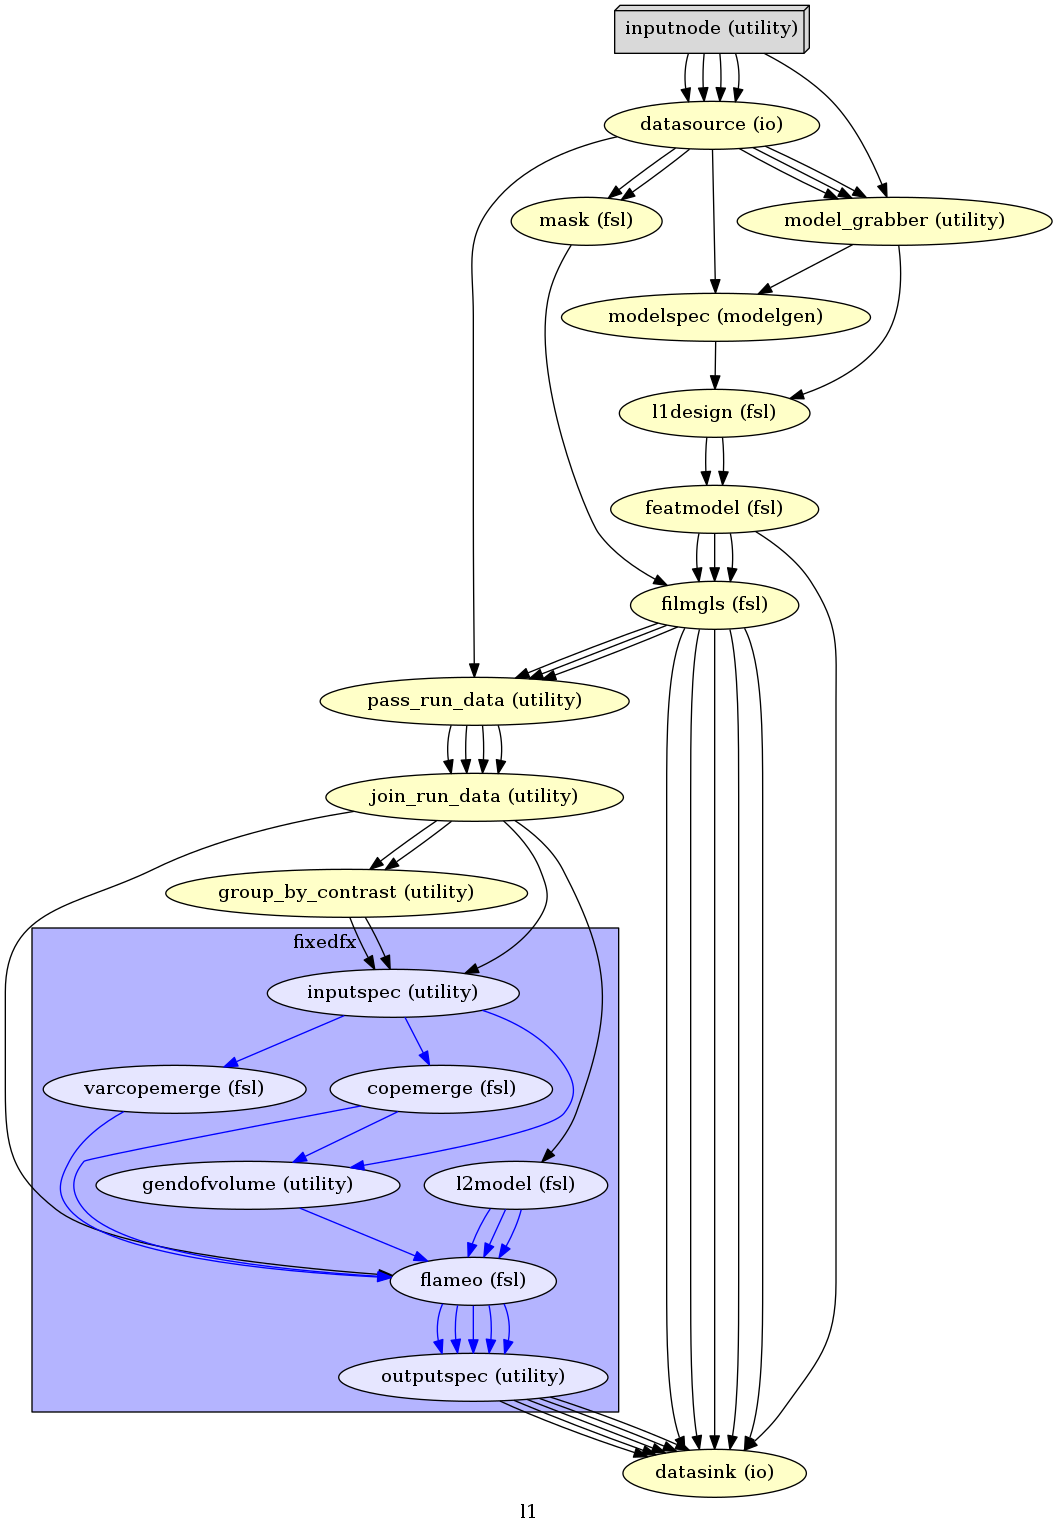

In [22]:
level1_workflow.write_graph(graph2use='colored', format='png', simple_form=True)
Image(filename=opj(level1_workflow.base_dir, 'l1', 'graph.png'))